In [1]:
import graphinf, midynet
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
from collections import defaultdict
import tqdm.notebook as tqdm

In [2]:
N, M = 3, 3
erdos = graphinf.graph.ErdosRenyiModel(N, M, with_self_loops=True, with_parallel_edges=True)
config = graphinf.graph.ConfigurationModelFamily(N, M, degree_prior_type="uniform")
sbm = graphinf.graph.StochasticBlockModelFamily(
    N, M, 
    block_prior_type="hyper", 
    with_self_loops=True, 
    with_parallel_edges=True
)

logp = dict(erdos=[], config=[])

for i, g in enumerate(graphinf.utility.enumerate_all_graphs(N, M, True, True)):
    erdos.set_state(g)
    config.set_state(g)
    logp["erdos"].append(erdos.get_log_joint())
    logp["config"].append(config.get_log_joint())
        
print(i)
logp["erdos"] = np.array(logp["erdos"])
logp["config"] = np.array(logp["config"])


55


In [5]:
graphs = ["erdos", "config", "sbm"]
for key in graphs:
    if key not in logp:
        continue
    print(f"Entropy ({key}): {-np.sum(logp['erdos'] * np.exp(logp['erdos'])):0.4f}")
    print(f"Normalization ({key}): {np.sum(np.exp(logp['erdos'])):0.4f}")
    for other in graphs:
        if other not in logp:
            continue
        ce = np.sum(np.exp(logp[key]) * logp[other])
        print(f"Cross entropy ({key}, {other}): {ce:0.4f}")


Entropy (erdos): 4.0254
Normalization (erdos): 1.0000
Cross entropy (erdos, erdos): -4.0254
Cross entropy (erdos, config): -4.2395
Entropy (config): 4.0254
Normalization (config): 1.0000
Cross entropy (config, erdos): -4.0254
Cross entropy (config, config): -3.8384


In [76]:
z = []

p = defaultdict(list)
for b in midynet.utility.enumerate_all_partitions(N, reduce=True):
    print(b)
    sbm.set_labels(b)
    logp = sbm.get_label_log_joint()
    z.append(logp)
    p[sbm.get_label_count()].append(b)
print(np.exp(midynet.utility.log_sum_exp(z)))

(0, 0, 0)
(0, 0, 1)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 2, 1)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 1, 0)
(1, 2, 0)
(2, 0, 1)
(2, 1, 0)
0.9999999999999996


## Probability of error

In [2]:

def log_evidence(model):
    N, M = model.graph_prior.get_size(), model.graph_prior.get_edge_count()
    sl, pe = model.graph_prior.with_self_loops(), model.graph_prior.with_parallel_edges()
    samples = []
    og = model.get_graph()
    for g in graphinf.utility.enumerate_all_graphs(N, M, sl, pe):
        model.set_graph(g)
        samples.append(model.get_log_joint())
    model.set_graph(og)
    return midynet.utility.log_sum_exp(samples)

def log_posterior(model):
    hxg = -model.get_log_likelihood()
    hg = -model.get_log_prior()
    hx = -log_evidence(model)
    return hx - hg - hxg

def mi(model):
    hxg = -model.get_log_likelihood()
    hx = -log_evidence(model)
    return hx - hxg
    
def recon(model, n_samples=100):
    mi_samples, hg_samples = [], []
    for _ in range(n_samples):
        model.sample()
        hg_samples.append(-model.get_log_prior())
        mi_samples.append(mi(model))
    return np.mean(mi_samples) / np.mean(hg_samples)
        
def error_prob(model, n_samples=100):
    samples = []
    for _ in range(n_samples):
        model.sample()
        samples.append(log_posterior(model))
    return 1 - np.exp(midynet.utility.log_mean_exp(samples))

def prior_entropy(model, n_samples=100):
    samples = []
    for _ in range(n_samples):
        model.sample()
        samples.append(-model.get_log_prior())
    return np.mean(samples)

def posterior_entropy(model, n_samples=100):
    samples = []
    for _ in range(n_samples):
        model.sample()
        samples.append(-log_posterior(model))
    return np.mean(samples)

def entropy(p):
    return - p * np.log(p) - (1 - p) * np.log(1 - p)

In [326]:
N, M = 5, 5
T = 100
n_samples = 100

x = np.linspace(0, 2, 20)
# data = defaultdict(list)

for _x in tqdm.tqdm(x):
    erdos = graphinf.graph.ErdosRenyiModel(N, M, with_self_loops=False, with_parallel_edges=False)
    model = graphinf.data.dynamics.GlauberDynamics(graph_prior=erdos, coupling=_x, length=T)
    Pe = error_prob(model, n_samples)
    He = entropy(Pe)
    Hg = prior_entropy(model, n_samples)
    Hgx = posterior_entropy(model, n_samples)
    r = (Hg - Hgx) / Hg
    data["coupling"].append(_x)
    data["error_prob"].append(Pe)
    data["lower_bound"].append(1 - r - He/Hg)
    data["upper_bound"].append(1 - np.exp(-Hgx))

df = pd.DataFrame(data)


  0%|          | 0/20 [00:00<?, ?it/s]

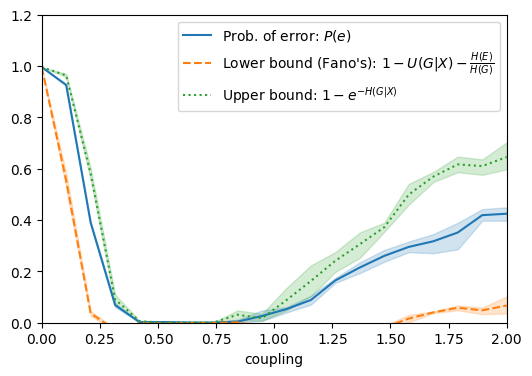

In [327]:

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.lineplot(df, x="coupling", y="error_prob", label=r"Prob. of error: $P(e)$", ax=ax)
sns.lineplot(df, x="coupling", y="lower_bound", linestyle="--", label=r"Lower bound (Fano's): $1 - U(G|X) - \frac{H(E)}{H(G)}$", ax=ax)
sns.lineplot(df, x="coupling", y="upper_bound", linestyle="dotted", label=r"Upper bound: $1 - e^{-H(G|X)}$", ax=ax)
ax.set_ylabel("")
ax.legend(loc="upper right")
ax.set_xlim([0, 2])
ax.set_ylim([0, 1.2])

fig.savefig("prob_of_error.png")

## Graph prior efficiency

In [4]:
N, M, T = 5, 5, 10
n_samples = 100

erdos = graphinf.graph.ErdosRenyiModel(
    N, 
    M, 
    with_self_loops=True, 
    with_parallel_edges=True
)
sbm = graphinf.graph.StochasticBlockModelFamily(
    N, M, 
    with_self_loops=True,
    with_parallel_edges=True,
    likelihood_type="uniform",
    block_prior_type="hyper",
    label_graph_prior_type="uniform"
)
dcsbm = graphinf.graph.StochasticBlockModelFamily(
    N, M, 
    with_self_loops=True,
    with_parallel_edges=True,
    likelihood_type="degree_corrected",
    block_prior_type="hyper",
    label_graph_prior_type="uniform"
)
cm = graphinf.graph.ConfigurationModelFamily(N, M)

graphs = dict(erdos=erdos, cm=cm, sbm=sbm, dcsbm=dcsbm)

### Cross-entropy of graph models

In [5]:
def graph_evidence(model):
    if issubclass(model.__class__, graphinf.data.DataModelWrapper):
        graph = model.graph_prior
    else:
        graph = model
    if not graph.labeled:
        return graph.get_log_joint()
    samples = []
    ob = graph.get_labels()
    for p in midynet.utility.enumerate_all_partitions(graph.get_size()):
        graph.set_labels(p)
        samples.append(graph.get_log_joint())
    graph.set_labels(ob)
    return midynet.utility.log_sum_exp(samples)

def mutualinfo(model):
    hg = -graph_evidence(model)
    hgx = -log_posterior(model)
    return hg - hgx

In [122]:
hg = defaultdict(list)

mode = "cm"
for _ in tqdm.tqdm(range(n_samples)):
    graphs[mode].sample()
    for n, g in graphs.items():
        if n != mode:
            g.set_state(graphs[mode].get_state())
        hg[n].append(graph_evidence(g))

  0%|          | 0/100 [00:00<?, ?it/s]

erdos   -9.361171
cm      -8.757365
sbm     -9.191947
dcsbm   -8.892125
dtype: float64


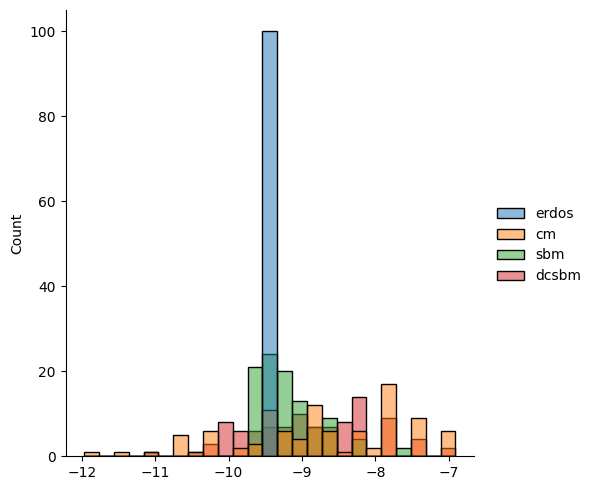

In [123]:
df = pd.DataFrame(hg)
sns.displot(df)
print(df.mean())

### Cross-mutual information

In [127]:
mi = defaultdict(list)

for _ in tqdm.tqdm(range(n_samples)):
    for n, g in graphs.items():
        model = graphinf.data.dynamics.GlauberDynamics(g, coupling=1, length=T)
        mi[n].append(mutualinfo(model))

  0%|          | 0/100 [00:00<?, ?it/s]

erdos    4.608525
cm       4.629463
sbm      4.973789
dcsbm    4.840881
dtype: float64


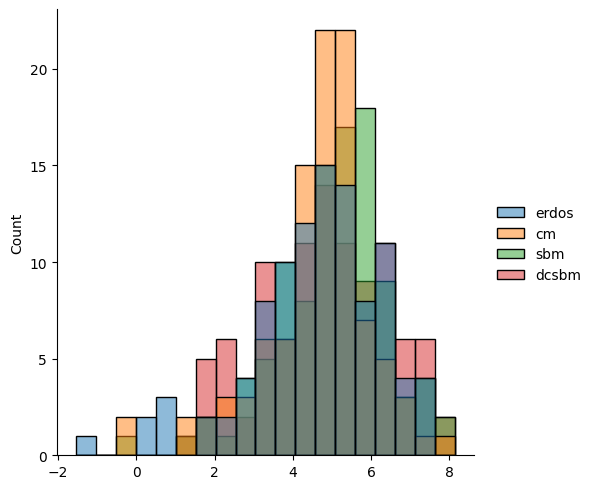

In [128]:
df = pd.DataFrame(mi)
sns.displot(df)
print(df.mean())

In [146]:
data = defaultdict(list)
mode = "erdos"
for _ in tqdm.tqdm(range(n_samples)):
    models = dict()
    for n, g in graphs.items():
        models[n] = graphinf.data.dynamics.GlauberDynamics(g, coupling=1, length=T)
    models[mode].sample()
    
    for n, g in graphs.items():
        if n != mode:
            models[n].set_state_from(models[mode].wrap)
        data[n].append(mutualinfo(models[n]))

  0%|          | 0/100 [00:00<?, ?it/s]

mode: sbm
erdos    4.677714
cm       4.735630
sbm      4.826583
dcsbm    4.520011
dtype: float64


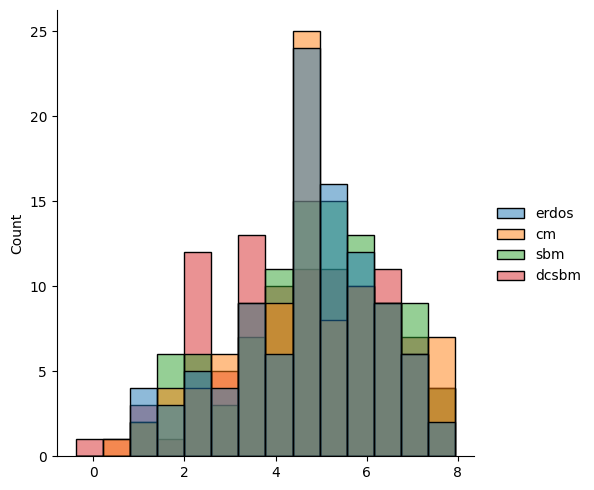

In [136]:
df = pd.DataFrame(data)
sns.displot(df)
print(f"mode: {mode}")
print(df.mean())

In [82]:
df.mean()


ErdosRenyiModel               2.636120
StochasticBlockModelFamily    2.621355
ConfigurationModelFamily      2.601645
dtype: float64

mode: cm
erdos    4.584939
cm       4.517797
sbm      4.134458
dcsbm    4.249438
dtype: float64


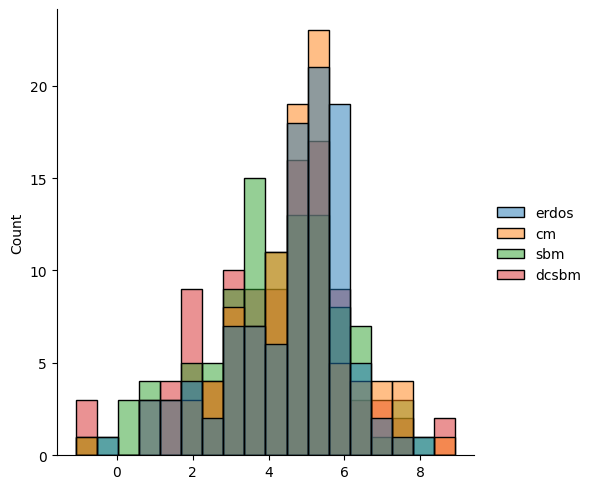

In [138]:
df = pd.DataFrame(data)
sns.displot(df)
print(f"mode: {mode}")
print(df.mean())


mode: dcsbm
erdos    4.384772
cm       4.247332
sbm      4.082840
dcsbm    4.581841
dtype: float64


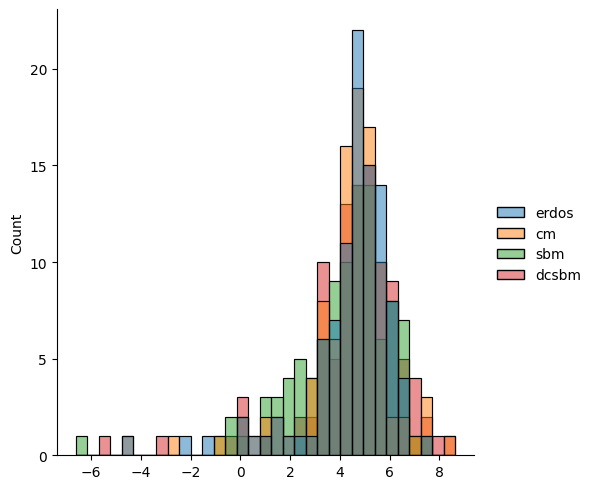

In [140]:
df = pd.DataFrame(data)
sns.displot(df)
print(f"mode: {mode}")
print(df.mean())


mode: erdos
erdos    4.658501
cm       4.798813
sbm      4.583470
dcsbm    4.472036
dtype: float64


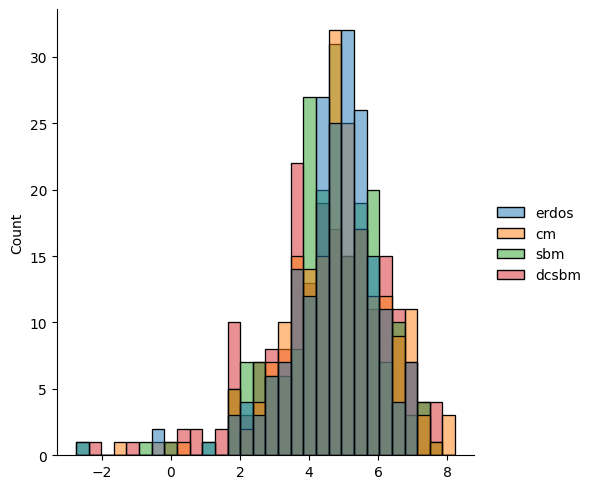

In [148]:
df = pd.DataFrame(data)
sns.displot(df)
print(f"mode: {mode}")
print(df.mean())


### Mutual information for little-rock model

In [100]:
import graphinf, midynet
import time
import matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sns

all_data = dict()

### Analysis with little rock

In [17]:
g0 = midynet.config.GraphConfig.littlerock()
g0 = midynet.config.GraphFactory.build(g0)
N, M = g0.get_size(), g0.get_total_edge_number()
avgk = np.sum(g0.get_adjacency_matrix(True), 0).mean()
T = 2 * N
J = 1. / avgk
x = graphinf.data.dynamics.GlauberDynamics(g0, coupling=J, length=T)

In [18]:
erdos = graphinf.graph.ErdosRenyiModel(N, M)
erdos = graphinf.data.dynamics.GlauberDynamics(erdos, coupling=J, length=T)

cm = graphinf.graph.ConfigurationModelFamily(N, M, degree_prior_type="uniform")
cm = graphinf.data.dynamics.GlauberDynamics(cm, coupling=J, length=T)

hcm = graphinf.graph.ConfigurationModelFamily(N, M, degree_prior_type="hyper")
hcm = graphinf.data.dynamics.GlauberDynamics(hcm, coupling=J, length=T)

sbm = graphinf.graph.StochasticBlockModelFamily(N, M, block_prior_type="hyper", likelihood_type="uniform")
sbm = graphinf.data.dynamics.GlauberDynamics(sbm, coupling=J, length=T)

dcsbm = graphinf.graph.StochasticBlockModelFamily(N, M, block_prior_type="hyper", likelihood_type="degree_corrected", degree_prior_type="uniform")
dcsbm = graphinf.data.dynamics.GlauberDynamics(dcsbm, coupling=J, length=T)

hdcsbm = graphinf.graph.StochasticBlockModelFamily(N, M, block_prior_type="hyper", likelihood_type="degree_corrected", degree_prior_type="hyper")
hdcsbm = graphinf.data.dynamics.GlauberDynamics(hdcsbm, coupling=J, length=T)


models = dict(erdos=erdos, cm=cm, hcm=hcm, sbm=sbm, dcsbm=dcsbm, hdcsbm=hdcsbm)

In [19]:
data = dict()

print("Graph marginal prior:")
for k, m in models.items():
    m.set_state_from(x.wrap)
    data[k, "prior"] = -m.graph_prior.get_log_evidence(g0)
    print('\t', k, data[k, "prior"])

print("Graph Posterior:")
for k, m in models.items():
    m.set_state_from(x.wrap)
    data[k, "posterior"] = -m.get_log_posterior(g0, method="meanfield", n_sweeps=1000)
    print('\t', k, data[k, "posterior"])
    data[k, "recon"] = (data[k, "prior"] - data[k, "posterior"]) / data[k, "prior"]

print("Graph-wise reconstructability")
for k in models.keys():
    print('\t', k, data[k, "recon"])

print("Graph-wise mutual information")
for k in models.keys():
    print("\t", k, data[k, "recon"] * data[k, "prior"])

all_data["littlerock"] = data

Graph marginal prior:
	 erdos 7381.745956365019
	 cm 6131.669102969439
	 hcm 6085.049995431762
	 sbm 7729.350001544587
	 dcsbm 7733.428221018815
	 hdcsbm 7773.777176141899
Graph Posterior:
	 erdos 6135.8567707025295
	 cm 5678.122590569461
	 hcm 5692.968858152617
	 sbm 6592.163910690228
	 dcsbm 6198.8428954847595
	 hdcsbm 6207.385421404678
Graph-wise reconstructability
	 erdos 0.16877974303466828
	 cm 0.07396787151810512
	 hcm 0.06443351124041587
	 sbm 0.1471257079349636
	 dcsbm 0.19843532281882179
	 hdcsbm 0.20149686815626178
Graph-wise mutual information
	 erdos 1245.8891856624896
	 cm 453.5465123999784
	 hcm 392.08113727914497
	 sbm 1137.1860908543595
	 dcsbm 1534.5853255340553
	 hdcsbm 1566.3917547372212


### Analysis with karate club

In [20]:
g0 = midynet.config.GraphConfig.karate()
g0 = midynet.config.GraphFactory.build(g0)
N, M = g0.get_size(), g0.get_total_edge_number()
avgk = np.sum(g0.get_adjacency_matrix(True), 0).mean()
T = 2 * N
J = 1./avgk
x = graphinf.data.dynamics.GlauberDynamics(g0, coupling=J, length=T)

In [21]:
erdos = graphinf.graph.ErdosRenyiModel(N, M)
erdos = graphinf.data.dynamics.GlauberDynamics(erdos, coupling=J, length=T)

cm = graphinf.graph.ConfigurationModelFamily(N, M, degree_prior_type="uniform")
cm = graphinf.data.dynamics.GlauberDynamics(cm, coupling=J, length=T)

hcm = graphinf.graph.ConfigurationModelFamily(N, M, degree_prior_type="hyper")
hcm = graphinf.data.dynamics.GlauberDynamics(hcm, coupling=J, length=T)

sbm = graphinf.graph.StochasticBlockModelFamily(N, M, block_prior_type="hyper", likelihood_type="uniform")
sbm = graphinf.data.dynamics.GlauberDynamics(sbm, coupling=J, length=T)

dcsbm = graphinf.graph.StochasticBlockModelFamily(N, M, block_prior_type="hyper", likelihood_type="degree_corrected", degree_prior_type="uniform")
dcsbm = graphinf.data.dynamics.GlauberDynamics(dcsbm, coupling=J, length=T)

hdcsbm = graphinf.graph.StochasticBlockModelFamily(N, M, block_prior_type="hyper", likelihood_type="degree_corrected", degree_prior_type="hyper")
hdcsbm = graphinf.data.dynamics.GlauberDynamics(hdcsbm, coupling=J, length=T)


models = dict(erdos=erdos, cm=cm, hcm=hcm, sbm=sbm, dcsbm=dcsbm, hdcsbm=hdcsbm)

In [22]:
data = dict()

print("Graph marginal prior:")
for k, m in models.items():
    m.set_state_from(x.wrap)
    data[k, "prior"] = -m.graph_prior.get_log_evidence(g0)
    print('\t', k, data[k, "prior"])

print("Graph Posterior:")
for k, m in models.items():
    m.set_state_from(x.wrap)
    data[k, "posterior"] = -m.get_log_posterior(g0, method="meanfield", n_sweeps=1000)
    print('\t', k, data[k, "posterior"])
    data[k, "recon"] = (data[k, "prior"] - data[k, "posterior"]) / data[k, "prior"]

print("Graph-wise reconstructability")
for k in models.keys():
    print('\t', k, data[k, "recon"])

print("Graph-wise mutual information")
for k in models.keys():
    print("\t", k, data[k, "recon"] * data[k, "prior"])
all_data["karate_club"] = data

Graph marginal prior:
	 erdos 240.10933852808193
	 cm 224.15397736287488
	 hcm 219.3971912712865
	 sbm 249.09486548585204
	 dcsbm 249.31356233432615
	 hdcsbm 251.47148584506994
Graph Posterior:
	 erdos 125.97167461546879
	 cm 115.2250772710275
	 hcm 112.81958022894936
	 sbm 128.8675879052165
	 dcsbm 125.74917308655704
	 hdcsbm 120.99724167810476
Graph-wise reconstructability
	 erdos 0.4753570378074412
	 cm 0.4859556871279882
	 hcm 0.48577472858598725
	 sbm 0.4826565868635463
	 dcsbm 0.49561840154556425
	 hdcsbm 0.5188430955840042
Graph-wise mutual information
	 erdos 114.13766391261315
	 cm 108.92890009184738
	 hcm 106.57761104233713
	 sbm 120.22727758063553
	 dcsbm 123.56438924776911
	 hdcsbm 130.47424416696518


### Analysis on political books

In [23]:
g0 = midynet.config.GraphConfig.polbooks()
g0 = midynet.config.GraphFactory.build(g0)
N, M = g0.get_size(), g0.get_total_edge_number()
avgk = np.sum(g0.get_adjacency_matrix(True), 0).mean()
T = 2 * N
J = 1./avgk
x = graphinf.data.dynamics.GlauberDynamics(g0, coupling=J, length=T)

erdos = graphinf.graph.ErdosRenyiModel(N, M)
erdos = graphinf.data.dynamics.GlauberDynamics(erdos, coupling=J, length=T)

cm = graphinf.graph.ConfigurationModelFamily(N, M, degree_prior_type="uniform")
cm = graphinf.data.dynamics.GlauberDynamics(cm, coupling=J, length=T)

hcm = graphinf.graph.ConfigurationModelFamily(N, M, degree_prior_type="hyper")
hcm = graphinf.data.dynamics.GlauberDynamics(hcm, coupling=J, length=T)

sbm = graphinf.graph.StochasticBlockModelFamily(N, M, block_prior_type="hyper", likelihood_type="uniform")
sbm = graphinf.data.dynamics.GlauberDynamics(sbm, coupling=J, length=T)

dcsbm = graphinf.graph.StochasticBlockModelFamily(N, M, block_prior_type="hyper", likelihood_type="degree_corrected", degree_prior_type="uniform")
dcsbm = graphinf.data.dynamics.GlauberDynamics(dcsbm, coupling=J, length=T)

hdcsbm = graphinf.graph.StochasticBlockModelFamily(N, M, block_prior_type="hyper", likelihood_type="degree_corrected", degree_prior_type="hyper")
hdcsbm = graphinf.data.dynamics.GlauberDynamics(hdcsbm, coupling=J, length=T)


models = dict(erdos=erdos, cm=cm, hcm=hcm, sbm=sbm, dcsbm=dcsbm, hdcsbm=hdcsbm)

In [24]:
data = dict()

print("Graph marginal prior:")
for k, m in models.items():
    m.set_state_from(x.wrap)
    data[k, "prior"] = -m.graph_prior.get_log_evidence(g0)
    print('\t', k, data[k, "prior"])

print("Graph Posterior:")
for k, m in models.items():
    m.set_state_from(x.wrap)
    data[k, "posterior"] = -m.get_log_posterior(g0, method="meanfield", n_sweeps=1000)
    print('\t', k, data[k, "posterior"])
    data[k, "recon"] = (data[k, "prior"] - data[k, "posterior"]) / data[k, "prior"]

print("Graph-wise reconstructability")
for k in models.keys():
    print('\t', k, data[k, "recon"])

print("Graph-wise mutual information")
for k in models.keys():
    print("\t", k, data[k, "recon"] * data[k, "prior"])
all_data["polbooks"] = data

Graph marginal prior:
	 erdos 1575.6502684899824
	 cm 1560.8964793449377
	 hcm 1541.923598821295
	 sbm 1613.292051433033
	 dcsbm 1619.1369960458444
	 hdcsbm 1621.3829261162248
Graph Posterior:
	 erdos 1027.1802943986097
	 cm 998.3787845230594
	 hcm 1001.4291258848249
	 sbm 1068.0645909559007
	 dcsbm 1034.728378193287
	 hdcsbm 1046.479630935238
Graph-wise reconstructability
	 erdos 0.3480911881651228
	 cm 0.36038116701880857
	 hcm 0.3505325901683096
	 sbm 0.3379595529481628
	 dcsbm 0.3609383389297902
	 hdcsbm 0.35457589069232387
Graph-wise mutual information
	 erdos 548.4699740913727
	 cm 562.5176948218783
	 hcm 540.4944729364701
	 sbm 545.2274604771324
	 dcsbm 584.4086178525574
	 hdcsbm 574.9032951809868


In [2]:
def f(g0, seed=None, verbose=False):
    if seed is None:
        graphinf.utility.seedWithTime()
    else:
        graphinf.utility.seed(seed)
        
    N, M = g0.get_size(), g0.get_total_edge_number()
    avgk = np.sum(g0.get_adjacency_matrix(True), 0).mean()
    T = 2 * N
    J = 1./avgk
    x = graphinf.data.dynamics.GlauberDynamics(g0, coupling=J, length=T)

    erdos = graphinf.graph.ErdosRenyiModel(N, M)
    erdos = graphinf.data.dynamics.GlauberDynamics(erdos, coupling=J, length=T)

    cm = graphinf.graph.ConfigurationModelFamily(N, M, degree_prior_type="uniform")
    cm = graphinf.data.dynamics.GlauberDynamics(cm, coupling=J, length=T)

    hcm = graphinf.graph.ConfigurationModelFamily(N, M, degree_prior_type="hyper")
    hcm = graphinf.data.dynamics.GlauberDynamics(hcm, coupling=J, length=T)

    sbm = graphinf.graph.StochasticBlockModelFamily(N, M, block_prior_type="hyper", likelihood_type="uniform")
    sbm = graphinf.data.dynamics.GlauberDynamics(sbm, coupling=J, length=T)

    dcsbm = graphinf.graph.StochasticBlockModelFamily(N, M, block_prior_type="hyper", likelihood_type="degree_corrected", degree_prior_type="uniform")
    dcsbm = graphinf.data.dynamics.GlauberDynamics(dcsbm, coupling=J, length=T)

    hdcsbm = graphinf.graph.StochasticBlockModelFamily(N, M, block_prior_type="hyper", likelihood_type="degree_corrected", degree_prior_type="hyper")
    hdcsbm = graphinf.data.dynamics.GlauberDynamics(hdcsbm, coupling=J, length=T)


    models = dict(erdos=erdos, cm=cm, hcm=hcm, sbm=sbm, dcsbm=dcsbm, hdcsbm=hdcsbm)
    
    data = dict()
    
    if verbose:
        print("Graph marginal prior:")
    for k, m in models.items():
        m.set_state_from(x.wrap)
        data[k, "prior"] = -m.graph_prior.get_log_evidence(g0)
        if verbose:
            print('\t', k, data[k, "prior"])

    if verbose:
        print("Graph Posterior:")
    for k, m in models.items():
        m.set_state_from(x.wrap)
        data[k, "posterior"] = -m.get_log_posterior(g0, method="meanfield", n_sweeps=1000)
        if verbose:
            print('\t', k, data[k, "posterior"])
        data[k, "recon"] = (data[k, "prior"] - data[k, "posterior"]) / data[k, "prior"]
    return data

## Cross measures

In [376]:
def posterior_similarity(g, p):
    return 1 - np.sum(np.abs(g - p)) / np.sum(np.abs(g + p))

def mean_absolute_error(g, p):
    N = g.shape[0]
    return 2 * np.sum(np.abs(g - p)) / (N * (N + 1))

def mean_square_error(g, p):
    N = g.shape[0]
    return 2 * np.sqrt(np.sum((g - p)**2)) / (N * (N + 1))

### Generation with SIS, reconstruction with Glauber

In [72]:
import graphinf, midynet
import matplotlib.pyplot as plt, numpy as np, pandas as pd

g = graphinf.graph.PlantedPartitionGraph(100, 250, 3, 0.5, with_self_loops=True, with_parallel_edges=True)
avgk = 5
generator = graphinf.data.dynamics.SISDynamics(g, infection_prob=0.2, length=200)

generator.sample(10)
g0 = g.get_state()

print(generator.get_log_likelihood())

-10573.578011527014


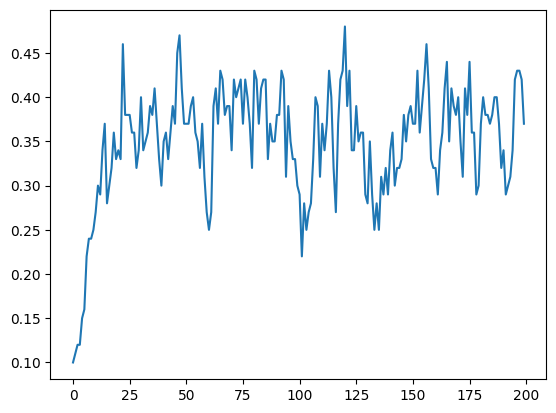

In [74]:
plt.plot(np.array(generator.get_past_states()).mean(0))

In [75]:
prior = graphinf.graph.ErdosRenyiModel(
    g.get_size(), 
    g.get_edge_count(),
)

reconstructor = graphinf.data.dynamics.GlauberDynamics(prior, coupling=1., length=generator.get_length())
reconstructor.set_state_from(generator.wrap)
reconstructor.freeze_graph_prior()
reconstructor.unfreeze_graph(10)
reconstructor.unfreeze_param(1)
# reconstructor.freeze_param("activation")
# reconstructor.freeze_param("deactivation")


# reconstructor.graph_prior.set_labels([0] * g.get_size())


In [76]:
collector = graphinf.utility.EdgeCollector()
collector.update(g0)
joint = []

for i in range(1000):
    reconstructor.metropolis_sweep(num_steps=g.get_size() * 10)
    collector.update(reconstructor.get_graph())
    joint.append(reconstructor.get_log_joint())
    if i%50 == 0:
        print(f"Epoch {i}: " \
              f"log(likelihood)={reconstructor.get_log_likelihood():0.4f}, "
              f"log(prior)={reconstructor.get_log_prior():0.4f}, " 
              f"coupling={reconstructor.get_coupling():0.4f}, "
              f"auto_act={reconstructor.get_auto_activation_prob():0.4f}, "
              f"auto_deact={reconstructor.get_auto_deactivation_prob():0.4f}, "
        )

Epoch 0: log(likelihood)=-14750.2427, log(prior)=-1002.8966, coupling=0.4131, auto_act=0.0751, auto_deact=0.1220, 
Epoch 50: log(likelihood)=-11545.6259, log(prior)=-1002.8966, coupling=0.1718, auto_act=0.0003, auto_deact=0.0001, 
Epoch 100: log(likelihood)=-11532.3932, log(prior)=-1002.8966, coupling=0.1737, auto_act=0.0001, auto_deact=0.0017, 
Epoch 150: log(likelihood)=-11538.8980, log(prior)=-1002.8966, coupling=0.1729, auto_act=0.0007, auto_deact=0.0041, 
Epoch 200: log(likelihood)=-11541.0971, log(prior)=-1002.8966, coupling=0.1741, auto_act=0.0003, auto_deact=0.0009, 
Epoch 250: log(likelihood)=-11547.5942, log(prior)=-1002.8966, coupling=0.1746, auto_act=0.0000, auto_deact=0.0004, 
Epoch 300: log(likelihood)=-11530.8500, log(prior)=-1002.8966, coupling=0.1715, auto_act=0.0002, auto_deact=0.0020, 
Epoch 350: log(likelihood)=-11574.1928, log(prior)=-1002.8966, coupling=0.1711, auto_act=0.0003, auto_deact=0.0000, 
Epoch 400: log(likelihood)=-11559.3059, log(prior)=-1002.8966, coup

In [86]:
np.mean(joint)

-12561.042870865998

In [79]:
hg = -prior.get_log_evidence(g0)
hgx = -collector.log_prob_estimate(g0)
print(hg, hgx, 1 - hgx / hg)


1002.8966111739282 998.6786777711608 0.004205750977491318


Text(0.5, 1.0, 'Infered graph')

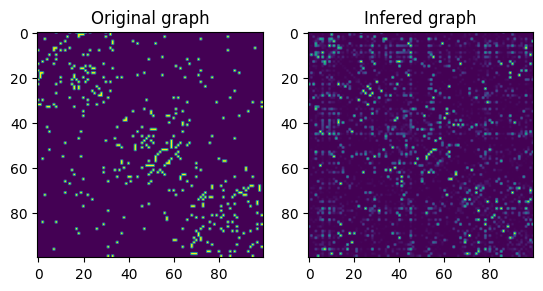

In [80]:
A = np.zeros((g.get_size(), g.get_size()))

for e in collector.multiplicities.keys():
    A[e[0], e[1]] = 1 - collector.mle(e, 0)
    A[e[1], e[0]] = 1 - collector.mle(e, 0)

fig, ax = plt.subplots(1, 2)
B = (np.array(generator.get_graph().get_adjacency_matrix(True)) > 0)
ax[0].imshow(B)
ax[0].set_title("Original graph")
ax[1].imshow(A)
ax[1].set_title("Infered graph")




In [81]:
prior = graphinf.graph.ErdosRenyiModel(
    g.get_size(), 
    g.get_edge_count(),
)

reconstructor = graphinf.data.dynamics.SISDynamics(prior, infection_prob=0.1, length=generator.get_length())
reconstructor.set_state_from(generator.wrap)
reconstructor.unfreeze_graph(10)
# reconstructor.freeze_param()
reconstructor.unfreeze_param(1)
# reconstructor.freeze_param("activation")
# reconstructor.freeze_param("deactivation")



In [82]:
collector = graphinf.utility.EdgeCollector()
collector.update(g0)

for i in range(1000):
    reconstructor.metropolis_sweep(num_steps=g.get_size() * 10)
    collector.update(reconstructor.get_graph())
    if i%50 == 0:
        print(f"Epoch {i}: " \
              f"log(likelihood)={reconstructor.get_log_likelihood():0.4f}, "
              f"log(prior)={reconstructor.get_log_prior():0.4f}, " 
              f"infection={reconstructor.get_infection_prob():0.4f}, "
              f"auto_act={reconstructor.get_auto_activation_prob():0.4f}, "
              f"auto_deact={reconstructor.get_auto_deactivation_prob():0.4f}, "
        )

Epoch 0: log(likelihood)=-10582.0284, log(prior)=-1002.8966, infection=0.1949, auto_act=0.0000, auto_deact=0.0094, 
Epoch 50: log(likelihood)=-10595.1163, log(prior)=-1002.8966, infection=0.1933, auto_act=0.0004, auto_deact=0.0038, 
Epoch 100: log(likelihood)=-10602.4198, log(prior)=-1002.8966, infection=0.1968, auto_act=0.0006, auto_deact=0.0050, 
Epoch 150: log(likelihood)=-10598.7939, log(prior)=-1002.8966, infection=0.1912, auto_act=0.0007, auto_deact=0.0112, 
Epoch 200: log(likelihood)=-10609.9081, log(prior)=-1002.8966, infection=0.1922, auto_act=0.0010, auto_deact=0.0258, 
Epoch 250: log(likelihood)=-10581.5661, log(prior)=-1002.8966, infection=0.1943, auto_act=0.0003, auto_deact=0.0028, 
Epoch 300: log(likelihood)=-10583.7953, log(prior)=-1002.8966, infection=0.1975, auto_act=0.0000, auto_deact=0.0075, 
Epoch 350: log(likelihood)=-10633.1173, log(prior)=-1002.8966, infection=0.1967, auto_act=0.0003, auto_deact=0.0020, 
Epoch 400: log(likelihood)=-10577.2604, log(prior)=-1002.89

In [83]:
hg = -prior.get_log_evidence(g0)
hgx = -collector.log_prob_estimate(g0)
print(hg, hgx, 1 - hgx / hg)

1002.8966111739282 295.5104404462819 0.7053430661208678


0.027976023976023976


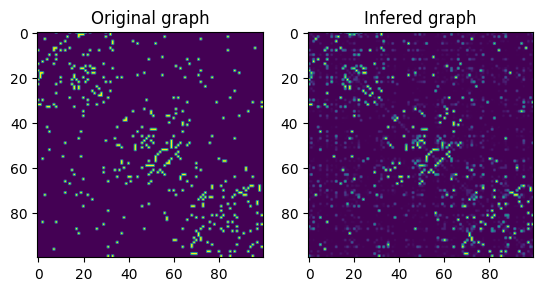

In [84]:
hg = -prior.get_log_evidence(g0)
hgx = -collector.log_prob_estimate(g0)
print(hg, hgx, 1 - hgx / hg)

A = np.zeros((100, 100))

for e in collector.multiplicities.keys():
    A[e[0], e[1]] = 1 - collector.mle(e, 0)
    A[e[1], e[0]] = 1 - collector.mle(e, 0)

fig, ax = plt.subplots(1, 2)
B = (np.array(generator.get_graph().get_adjacency_matrix(True)) > 0)
ax[0].imshow(B)
ax[0].set_title("Original graph")
ax[1].imshow(A)
ax[1].set_title("Infered graph")
print(np.abs(A - B).mean())


### Generation with CM, reconstruction with Erdos

-11636.008051910629


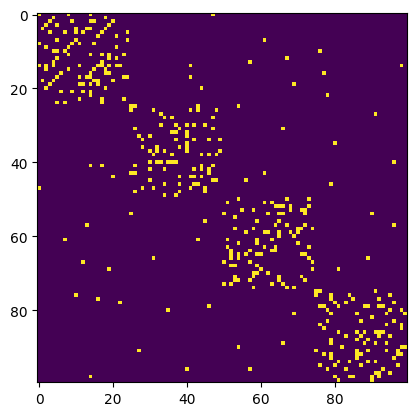

In [352]:
import graphinf, midynet
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from graph_tool.inference import mutual_information

g = graphinf.graph.PlantedPartitionGraph(100, 250, block_count=4, assortativity=0.8)
generator = graphinf.data.dynamics.GlauberDynamics(g, coupling=1./5, length=2 * g.get_size())

generator.sample()
g0 = g.get_state()

print(generator.get_log_likelihood())

B = (np.array(generator.get_graph().get_adjacency_matrix(True)) > 0)
plt.imshow(B)

In [353]:
prior = graphinf.graph.ErdosRenyiModel(
    g.get_size(), 
    g.get_edge_count(),
)

reconstructor = graphinf.data.dynamics.GlauberDynamics(
    prior, 
    coupling=generator.get_coupling(), 
    length=generator.get_length()
)
reconstructor.set_state_from(generator.wrap)
reconstructor.sample_prior()
reconstructor.freeze_graph_prior()
reconstructor.freeze_param()
# reconstructor.unfreeze_param(1)
# reconstructor.freeze_param("activation")
# reconstructor.freeze_param("deactivation")



Epoch 0: time=0.0920, log(likelihood)=-13821.1772, log(prior)=-999.8305, 
Epoch 50: time=0.0560, log(likelihood)=-11623.5851, log(prior)=-999.8305, 
Epoch 100: time=0.0561, log(likelihood)=-11605.5486, log(prior)=-999.8305, 
Epoch 150: time=0.0548, log(likelihood)=-11613.2375, log(prior)=-999.8305, 
Epoch 200: time=0.0583, log(likelihood)=-11583.8253, log(prior)=-999.8305, 
Epoch 250: time=0.0575, log(likelihood)=-11615.7687, log(prior)=-999.8305, 
Epoch 300: time=0.0553, log(likelihood)=-11622.2231, log(prior)=-999.8305, 
Epoch 350: time=0.0555, log(likelihood)=-11592.2141, log(prior)=-999.8305, 
Epoch 400: time=0.0553, log(likelihood)=-11602.6921, log(prior)=-999.8305, 
Epoch 450: time=0.0565, log(likelihood)=-11589.0377, log(prior)=-999.8305, 
Epoch 500: time=0.0550, log(likelihood)=-11607.2934, log(prior)=-999.8305, 
Epoch 550: time=0.0550, log(likelihood)=-11632.5015, log(prior)=-999.8305, 
Epoch 600: time=0.0559, log(likelihood)=-11633.4811, log(prior)=-999.8305, 
Epoch 650: time

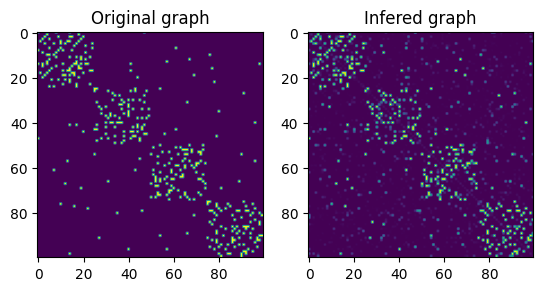

In [354]:
collector = graphinf.utility.EdgeCollector()
collector.update(g0)

for i in range(1000):
    t0 = time.time()
    reconstructor.metropolis_sweep(num_steps=g.get_size() * 10)
    t1 = time.time()
    collector.update(reconstructor.get_graph())
    if i%50 == 0:
        print(f"Epoch {i}: " \
              f"time={t1 - t0:0.4f}, "
              f"log(likelihood)={reconstructor.get_log_likelihood():0.4f}, "
              f"log(prior)={reconstructor.get_log_prior():0.4f}, " 
#               f"infection={reconstructor.get_infection_prob():0.4f}, "
#               f"auto_act={reconstructor.get_auto_activation_prob():0.4f}, "
#               f"auto_deact={reconstructor.get_auto_deactivation_prob():0.4f}, "
        )
        
        
hg = -prior.get_log_evidence(g0)
hgx = -collector.log_prob_estimate(g0)

P = np.zeros((g0.get_size(), g0.get_size()))

for e in collector.multiplicities.keys():
    P[e[0], e[1]] = 1 - collector.mle(e, 0)
    P[e[1], e[0]] = 1 - collector.mle(e, 0)

fig, ax = plt.subplots(1, 2)
A = (np.array(generator.get_graph().get_adjacency_matrix(True)) > 0)
ax[0].imshow(A)
ax[0].set_title("Original graph")
ax[1].imshow(P)
ax[1].set_title("Infered graph")

print(f"Graph entropy: {hg:0.4f}, "
      f"Graph Posterior entropy: {hgx:0.4f}, "
      f"Reconstructability: {1 - hgx / hg:0.4f}, "
      f"Posterior similarity: {posterior_similarity(A, P):0.4f}")


In [355]:
prior = graphinf.graph.ConfigurationModelFamily(
    g.get_size(), 
    g.get_edge_count(),
)

reconstructor = graphinf.data.dynamics.GlauberDynamics(
    prior, 
    coupling=generator.get_coupling(), 
    length=generator.get_length()
)
reconstructor.set_state_from(generator.wrap)
reconstructor.sample_prior()
reconstructor.unfreeze_graph(1)
reconstructor.freeze_graph_prior()
reconstructor.freeze_param()
# reconstructor.unfreeze_param(1)
# reconstructor.freeze_param("activation")
# reconstructor.freeze_param("deactivation")



Epoch 0: time=0.0676, log(likelihood)=-13727.3952, log(prior)=-1015.5863, 
Epoch 50: time=0.0578, log(likelihood)=-11648.1059, log(prior)=-1071.5169, 
Epoch 100: time=0.0580, log(likelihood)=-11609.7695, log(prior)=-1078.6760, 
Epoch 150: time=0.0559, log(likelihood)=-11630.1855, log(prior)=-1069.5570, 
Epoch 200: time=0.0564, log(likelihood)=-11654.6853, log(prior)=-1062.1745, 
Epoch 250: time=0.0559, log(likelihood)=-11607.6257, log(prior)=-1064.8029, 
Epoch 300: time=0.0558, log(likelihood)=-11632.6062, log(prior)=-1073.8672, 
Epoch 350: time=0.0556, log(likelihood)=-11573.8708, log(prior)=-1074.7504, 
Epoch 400: time=0.0562, log(likelihood)=-11625.6661, log(prior)=-1062.6739, 
Epoch 450: time=0.0553, log(likelihood)=-11619.1961, log(prior)=-1071.2781, 
Epoch 500: time=0.0561, log(likelihood)=-11620.7902, log(prior)=-1065.6888, 
Epoch 550: time=0.0564, log(likelihood)=-11618.4480, log(prior)=-1072.3188, 
Epoch 600: time=0.0553, log(likelihood)=-11645.3005, log(prior)=-1062.1663, 
Ep

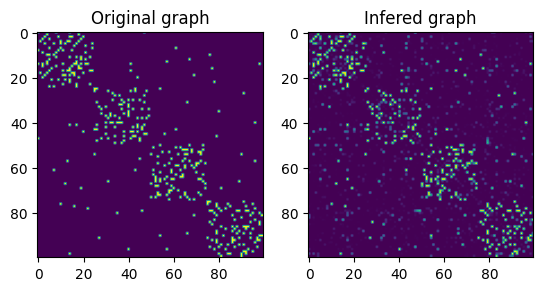

In [356]:
collector = graphinf.utility.EdgeCollector()
collector.update(g0)

for i in range(1000):
    t0 = time.time()
    reconstructor.metropolis_sweep(num_steps=g.get_size() * 10)
    t1 = time.time()
    collector.update(reconstructor.get_graph())
    if i%50 == 0:
        print(f"Epoch {i}: " \
              f"time={t1 - t0:0.4f}, "
              f"log(likelihood)={reconstructor.get_log_likelihood():0.4f}, "
              f"log(prior)={reconstructor.get_log_prior():0.4f}, " 
#               f"infection={reconstructor.get_infection_prob():0.4f}, "
#               f"auto_act={reconstructor.get_auto_activation_prob():0.4f}, "
#               f"auto_deact={reconstructor.get_auto_deactivation_prob():0.4f}, "
        )
        
        
hg = -prior.get_log_evidence(g0)
hgx = -collector.log_prob_estimate(g0)

P = np.zeros((g0.get_size(), g0.get_size()))

for e in collector.multiplicities.keys():
    P[e[0], e[1]] = 1 - collector.mle(e, 0)
    P[e[1], e[0]] = 1 - collector.mle(e, 0)

fig, ax = plt.subplots(1, 2)
A = (np.array(generator.get_graph().get_adjacency_matrix(True)) > 0)
ax[0].imshow(A)
ax[0].set_title("Original graph")
ax[1].imshow(P)
ax[1].set_title("Infered graph")

print(f"Graph entropy: {hg:0.4f}, "
      f"Graph Posterior entropy: {hgx:0.4f}, "
      f"Reconstructability: {1 - hgx / hg:0.4f}, "
      f"Posterior similarity: {posterior_similarity(A, P):0.4f}")


In [368]:
prior = graphinf.graph.StochasticBlockModelFamily(
    g.get_size(), 
    g.get_edge_count(),
    block_prior_type="hyper",
    sample_label_count_prob=0.1,
)

reconstructor = graphinf.data.dynamics.GlauberDynamics(
    prior, 
    coupling=generator.get_coupling(), 
    length=generator.get_length()
)
reconstructor.set_state_from(generator.wrap)
reconstructor.sample_prior()
reconstructor.graph_prior.set_labels([0] * 100)
# reconstructor.graph_prior.set_labels(g.get_labels())
reconstructor.unfreeze_graph(1)
reconstructor.unfreeze_graph_prior(1)
# reconstructor.freeze_graph_prior()
reconstructor.freeze_param()
# reconstructor.unfreeze_param(1)
# reconstructor.freeze_param("activation")
# reconstructor.freeze_param("deactivation")




In [381]:
prior.set_state(g.get_state())
prior.sample_only_labels()
print(prior.get_label_count())
partitions = []
for i in range(1000):
    t0 = time.time()
    prior.metropolis_sweep(num_steps=g.get_size() * 20)
    t1 = time.time()
    partitions.append(prior.get_labels())
    if i%50 == 0:
        print(f"Epoch {i}: " \
              f"time={t1 - t0:0.4f}, "
              f"log(likelihood)={prior.get_log_likelihood():0.4f}, "
              f"log(prior)={prior.get_log_prior():0.4f}, "
              f"# of blocks={B}, "
#               f"infection={reconstructor.get_infection_prob():0.4f}, "
#               f"auto_act={reconstructor.get_auto_activation_prob():0.4f}, "
#               f"auto_deact={reconstructor.get_auto_deactivation_prob():0.4f}, "
        )
p0 = g.get_labels()
mi = np.mean([mutual_information(p0, p, norm=True) for p in partitions])
print(mi)

99
Epoch 0: time=0.0618, log(likelihood)=-462.8358, log(prior)=-842.9571, # of blocks=32, 
Epoch 50: time=0.0618, log(likelihood)=-471.0552, log(prior)=-847.6599, # of blocks=32, 
Epoch 100: time=0.0618, log(likelihood)=-490.4791, log(prior)=-845.9859, # of blocks=32, 
Epoch 150: time=0.0618, log(likelihood)=-472.7195, log(prior)=-846.4435, # of blocks=32, 
Epoch 200: time=0.0618, log(likelihood)=-481.2048, log(prior)=-846.2736, # of blocks=32, 
Epoch 250: time=0.0618, log(likelihood)=-477.9910, log(prior)=-844.5463, # of blocks=32, 
Epoch 300: time=0.0618, log(likelihood)=-466.3006, log(prior)=-844.2868, # of blocks=32, 
Epoch 350: time=0.0618, log(likelihood)=-474.7235, log(prior)=-844.7977, # of blocks=32, 
Epoch 400: time=0.0618, log(likelihood)=-476.4558, log(prior)=-846.1194, # of blocks=32, 
Epoch 450: time=0.0618, log(likelihood)=-474.6355, log(prior)=-847.1002, # of blocks=32, 
Epoch 500: time=0.0618, log(likelihood)=-471.6618, log(prior)=-847.8830, # of blocks=32, 
Epoch 550:

Epoch 0: time=0.0830, log(likelihood)=-14901.5290, log(prior)=-1320.5499, # of blocks=32, 
Epoch 50: time=0.0611, log(likelihood)=-14672.9777, log(prior)=-1318.7779, # of blocks=32, 
Epoch 100: time=0.0625, log(likelihood)=-14642.1263, log(prior)=-1312.6877, # of blocks=32, 
Epoch 150: time=0.0614, log(likelihood)=-14614.1721, log(prior)=-1318.7891, # of blocks=32, 
Epoch 200: time=0.0624, log(likelihood)=-14614.5709, log(prior)=-1296.7644, # of blocks=32, 
Epoch 250: time=0.0621, log(likelihood)=-14606.8490, log(prior)=-1313.7061, # of blocks=32, 
Epoch 300: time=0.0619, log(likelihood)=-14610.9617, log(prior)=-1312.1364, # of blocks=32, 
Epoch 350: time=0.0618, log(likelihood)=-14617.1408, log(prior)=-1313.3195, # of blocks=32, 
Epoch 400: time=0.0639, log(likelihood)=-14611.9818, log(prior)=-1312.6272, # of blocks=32, 
Epoch 450: time=0.0619, log(likelihood)=-14606.8882, log(prior)=-1317.9997, # of blocks=32, 
Epoch 500: time=0.0693, log(likelihood)=-14603.3855, log(prior)=-1311.334

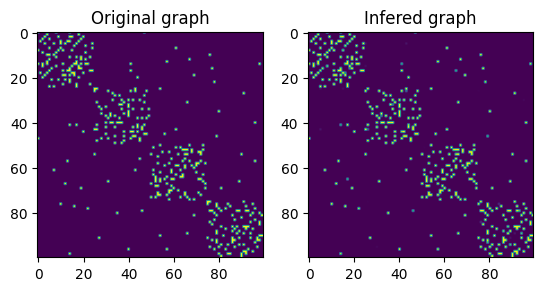

In [382]:
collector = graphinf.utility.EdgeCollector()
collector.update(g0)
partitions = []


for i in range(1000):
    t0 = time.time()
    reconstructor.metropolis_sweep(num_steps=g.get_size() * 20)
    t1 = time.time()
    collector.update(reconstructor.get_graph())
    partitions.append(reconstructor.graph_prior.get_labels())
    B = len(np.unique(partitions[-1]))
    if i%50 == 0:
        print(f"Epoch {i}: " \
              f"time={t1 - t0:0.4f}, "
              f"log(likelihood)={reconstructor.get_log_likelihood():0.4f}, "
              f"log(prior)={reconstructor.get_log_prior():0.4f}, "
              f"# of blocks={B}, "
#               f"infection={reconstructor.get_infection_prob():0.4f}, "
#               f"auto_act={reconstructor.get_auto_activation_prob():0.4f}, "
#               f"auto_deact={reconstructor.get_auto_deactivation_prob():0.4f}, "
        )
        
hg = -prior.get_log_evidence(g0)
hgx = -collector.log_prob_estimate(g0)

P = np.zeros((g0.get_size(), g0.get_size()))

for e in collector.multiplicities.keys():
    P[e[0], e[1]] = 1 - collector.mle(e, 0)
    P[e[1], e[0]] = 1 - collector.mle(e, 0)

fig, ax = plt.subplots(1, 2)
A = (np.array(generator.get_graph().get_adjacency_matrix(True)) > 0)
ax[0].imshow(A)
ax[0].set_title("Original graph")
ax[1].imshow(P)
ax[1].set_title("Infered graph")

p0 = generator.graph_prior.get_labels()
mi = np.mean([mutual_information(p0, p) for p in partitions])

print(f"Graph entropy: {hg:0.4f}, "
      f"Graph Posterior entropy: {hgx:0.4f}, "
      f"Reconstructability: {1 - hgx / hg:0.4f}, "
      f"Posterior similarity: {posterior_similarity(A, P):0.4f}, "
      f"MI: {mi:0.4f}"
)


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]